In [ ]:
# import and install required libraries.
import requests
import os
from os import path
import csv
import random
import numpy as np
import pandas as pd
import time
import re
import json
from sentence_transformers.readers import InputExample
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

Load + Prepare Data:

In [ ]:
# create mount point.
mount_dir = '/content/nextcloud'
os.makedirs(mount_dir, exist_ok=True)

In [ ]:
webdav_url = "https://cloud.uni-konstanz.de/remote.php/dav/files/removed"
username = "removed"
password = "removed!"

In [ ]:
!curl -u "removed:removed!" -o model.zip "https://cloud.uni-konstanz.de/remote.php/dav/files/removed/model.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  485M  100  485M    0     0  29.9M      0  0:00:16  0:00:16 --:--:-- 33.5M


In [ ]:
# load best performing model.
with zipfile.ZipFile("model.zip", 'r') as zip_ref:
    zip_ref.extractall(mount_dir)

model_path = os.path.join(mount_dir, "content/models/finetuned/final")
model = SentenceTransformer(model_path)

In [ ]:
!curl -u "removed:removed!" -o genius_cleaned_merged.json "https://cloud.uni-konstanz.de/remote.php/dav/files/removed/genius_cleaned_merged.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.9M  100 12.9M    0     0  5978k      0  0:00:02  0:00:02 --:--:-- 5979k


In [ ]:
# load data.
with open("genius_cleaned_merged.json", "r") as f:
    data = json.load(f)

df_full = pd.DataFrame(data)

# process release date + create 'year' column.
df_full['release_date'] = pd.to_datetime(df_full['release_date'], errors='coerce')
df_full['year'] = df_full['release_date'].dt.year

# keep columns I want for analysis.
columns_to_keep = ["lyrics_clean", "primary_tag", "year", "artist"]
df = df_full[columns_to_keep].copy()

# drop rows with missing values.
df = df.dropna().reset_index(drop=True)

# make sure 'year' is an integer.
df['year'] = df['year'].astype(int)

In [ ]:
!curl -u "removed:removed!" -o EDA_df.csv "https://cloud.uni-konstanz.de/remote.php/dav/files/removed/EDA_df.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62.6M  100 62.6M    0     0  16.1M      0  0:00:03  0:00:03 --:--:-- 16.1M


In [ ]:
# load data with topics.
df_full_topics = pd.read_csv("EDA_df.csv")

# process release date + create 'year' column
df_full_topics['release_date'] = pd.to_datetime(df_full_topics['release_date'], errors='coerce')
df_full_topics['year'] = df_full_topics['release_date'].dt.year

# keep columns I want for analysis.
columns_to_keep_topics = ["lyrics_clean", "topic_name", "year", "artist"]
df_topics = df_full_topics[columns_to_keep_topics].copy()

# drop rows with missing values
df_topics = df_topics.dropna().reset_index(drop=True)

# make sure 'year' is an integer
df_topics['year'] = df_topics['year'].astype(int)

Generate Embeddings:

In [ ]:
# use encode function on the 'lyrics_clean' column.
embeddings = model.encode(df['lyrics_clean'].tolist(), show_progress_bar=True, convert_to_numpy=True)

# shape = (number of lyrics (text of one whole song), number of dimensions in each embedding).
print(f"Embeddings created successfully with shape: {embeddings.shape}")

Batches:   0%|          | 0/99 [00:00<?, ?it/s]

Embeddings created successfully with shape: (3152, 384)


In [ ]:
# embeddings for topics.

# use encode function on the 'lyrics_clean' column.
embeddings_topics = model.encode(df_topics['lyrics_clean'].tolist(), show_progress_bar=True, convert_to_numpy=True)

# shape = (number of lyrics (text of one whole song), number of dimensions in each embedding).
print(f"Embeddings (for topics) created successfully with shape: {embeddings_topics.shape}")

Batches:   0%|          | 0/818 [00:00<?, ?it/s]

Embeddings (for topics) created successfully with shape: (26167, 384)


Scale Embeddings:

In [ ]:
# initialize the scaler.
scaler = StandardScaler()

# fit the scaler to the embeddings and transform them.
scaled_embeddings = scaler.fit_transform(embeddings)

In [ ]:
# scale embeddings for topics

# initialize the scaler.
scaler = StandardScaler()

# fit the scaler to the embeddings and transform them.
scaled_embeddings_topics = scaler.fit_transform(embeddings_topics)

Apply PCA for Dimensionality Reduction:


In [ ]:
# reduce the dimensionality from its original shape down to 2.

# initialize PCA to find the top 2 principal components.
pca = PCA(n_components=2)

# run PCA on the scaled embeddings.
pca_result = pca.fit_transform(scaled_embeddings)

print(f"PCA complete. New data shape: {pca_result.shape}")

# add PCA results to original df.
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

print("PCA components added to the DataFrame. Updated head:")
print(df.head())

PCA complete. New data shape: (3152, 2)
PCA components added to the DataFrame. Updated head:
                                        lyrics_clean primary_tag  year  \
0  want lot christmas one thing need care present...         r&b  1994   
1  bye bye bye doin tonight probably gonna start ...         pop  2000   
2  gon make lose mind gon make go gon make act fo...         rap  1999   
3  look one shot one opportunity seize everything...         pop  2002   
4  arf arf get twisted rap shit mine motherfucker...         rap  2003   

         artist      pca_1      pca_2  
0  Mariah Carey  -5.110754 -11.126882  
1        *NSYNC -12.509724   0.090988  
2           DMX  13.810224   1.680932  
3        Eminem   1.813920  -8.676303  
4           DMX  13.545749   1.050399  


In [ ]:
# pca for topics.

# initialize PCA to find the top 2 principal components.
pca = PCA(n_components=2)

# run PCA on the scaled embeddings.
pca_result_topics = pca.fit_transform(scaled_embeddings_topics)

print(f"PCA complete. New data shape: {pca_result_topics.shape}")

# add PCA results to original df.
df_topics['pca_1'] = pca_result_topics[:, 0]
df_topics['pca_2'] = pca_result_topics[:, 1]

print("PCA components added to the DataFrame (with topics). Updated head:")
print(df_topics.head())

PCA complete. New data shape: (26167, 2)
PCA components added to the DataFrame (with topics). Updated head:
                                        lyrics_clean          topic_name  \
0  want lot christmas one thing need care present...     Love & Devotion   
1  mood right mood say got girl want want got gir...     Love & Devotion   
2  dj chose bro bro nigga homie count money fuck ...         Rap/Hip-Hop   
3  one talkin sleep night makin crazy wrote read ...  Romantic Struggles   
4  wonderful time year kids jingle belling everyo...     Love & Devotion   

   year                      artist      pca_1      pca_2  
0  1994                Mariah Carey   2.503309 -11.132605  
1  2017                         SZA  -3.403323  -8.964769  
2  2017  YoungBoy Never Broke Again  14.728789   6.676497  
3  2017                    Dua Lipa  -4.141688 -11.206728  
4  1963              and y Williams -13.047280  -0.112911  


Visualization 1: PCA Results

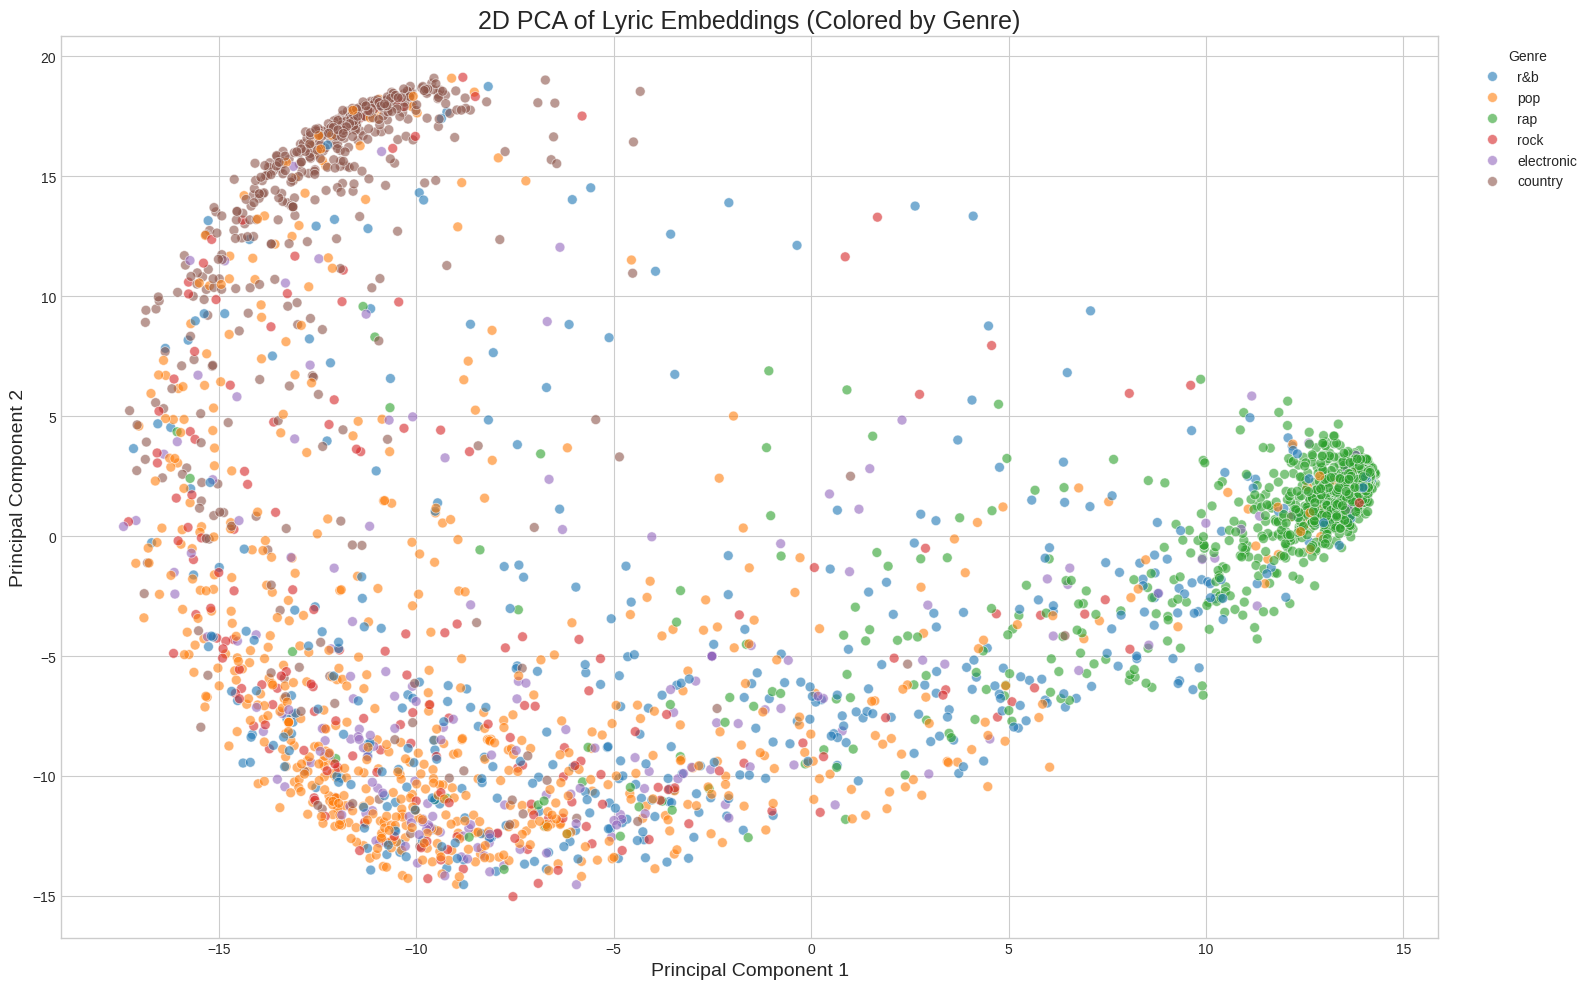

In [ ]:
# create scatter plot w/ two PCA components.
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 10))

# color points based on genre and only plot 6 most common genres.
top_genres = df['primary_tag'].value_counts().nlargest(6).index
df_subset = df[df['primary_tag'].isin(top_genres)]

scatter_plot = sns.scatterplot(data=df_subset, x='pca_1', y='pca_2', hue='primary_tag', alpha=0.6, s=50)

plt.title('2D PCA of Lyric Embeddings (Colored by Genre)', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Lyrical content in rap music (green) is thematically distinct and consistent enough to be clearly separated from all other genres. Pop (orange), r&b (blue), rock (red), country (purple), and electronic (brown) are heavily intermingled, suggeting they share common lyrical themes.

Principal Component 1: this axis captures the most significant thematic difference across all the lyrics in the data set. The axis separates rap (high postive values) from pop/r&b/rock (negative values).

Principal Component 2: this axis represents the second most significant variation. As we can see in the arch in the left, the points are creating a curve, which shows country at the top and pop towards the bottom.

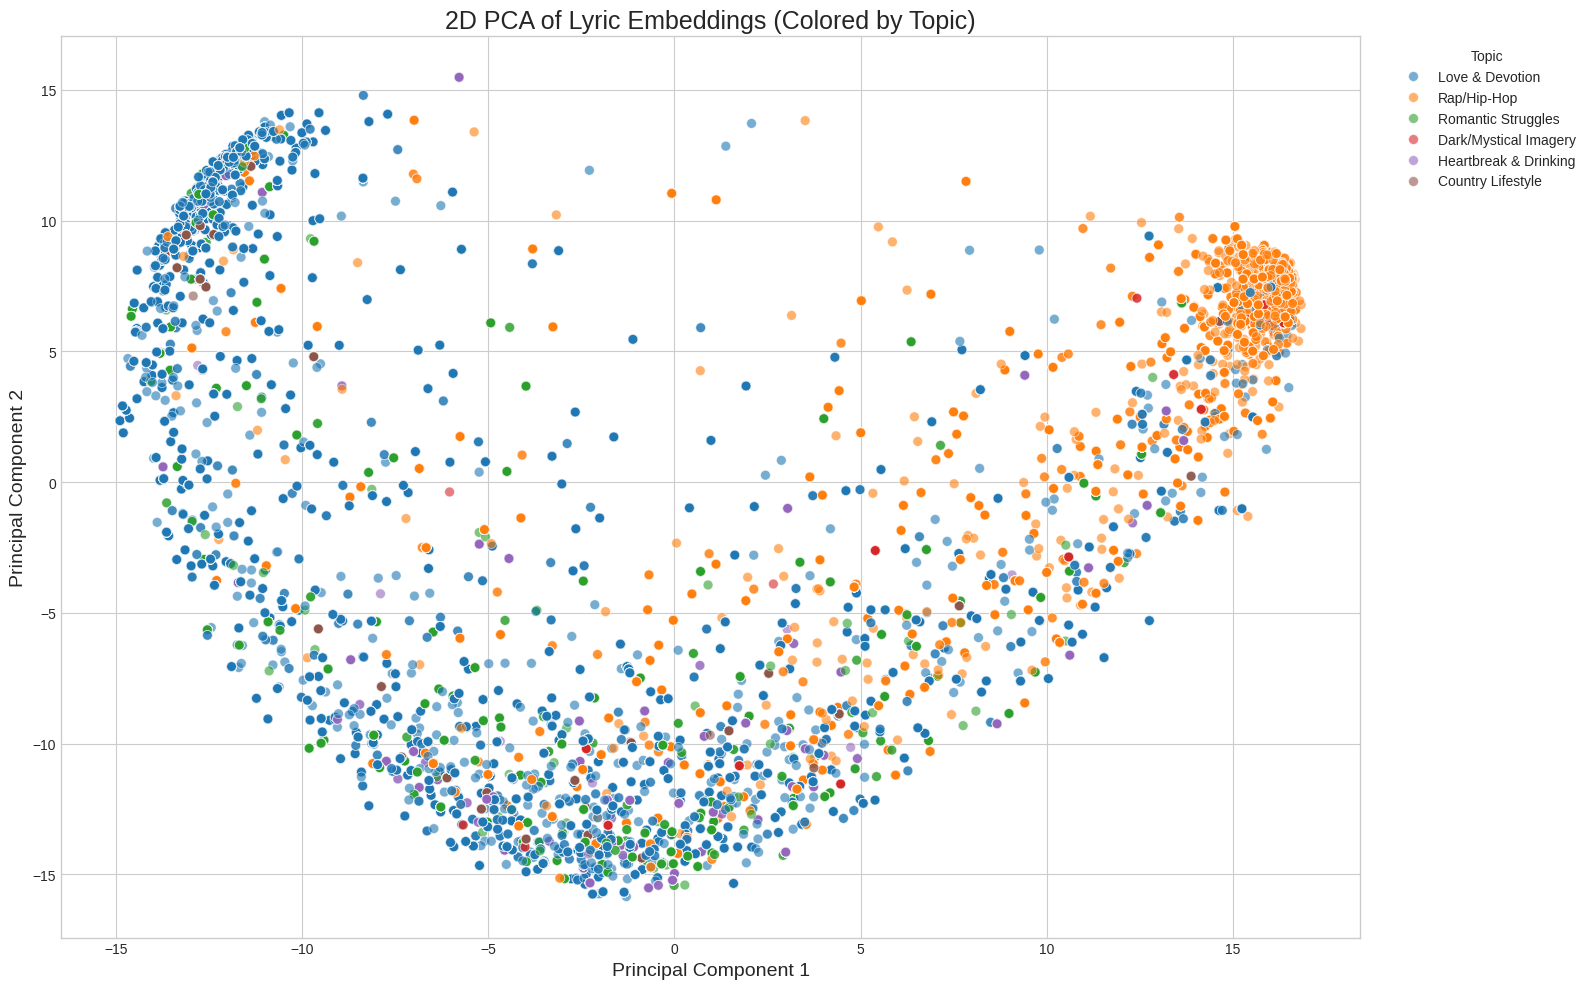

In [ ]:
# PCA result visualization with topics
# create scatter plot w/ two PCA components.
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 10))

# color points based on genre and only plot 6 most common genres.
top_topics = df_topics['topic_name'].value_counts().nlargest(6).index
df_topic_subset = df_topics[df_topics['topic_name'].isin(top_topics)]

scatter_plot = sns.scatterplot(data=df_topic_subset, x='pca_1', y='pca_2', hue='topic_name', alpha=0.6, s=50)

plt.title('2D PCA of Lyric Embeddings (Colored by Topic)', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Topic', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Visualization 2: Artist Trajectory Over Time


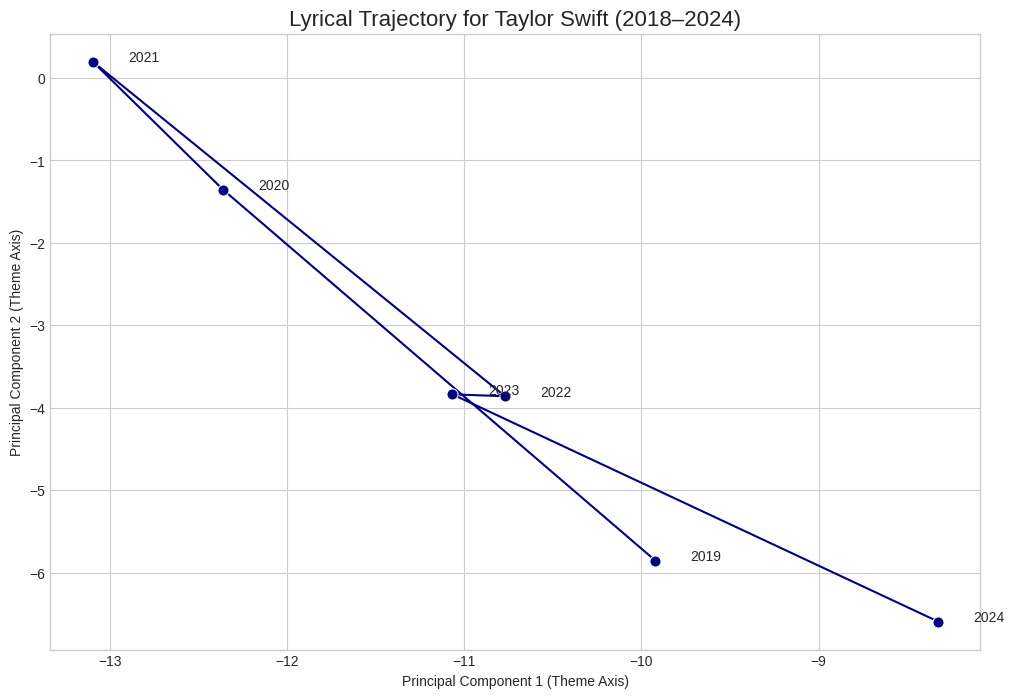

In [35]:
# 1

# artist and time frame for COVID.
artist_name = 'Taylor Swift'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

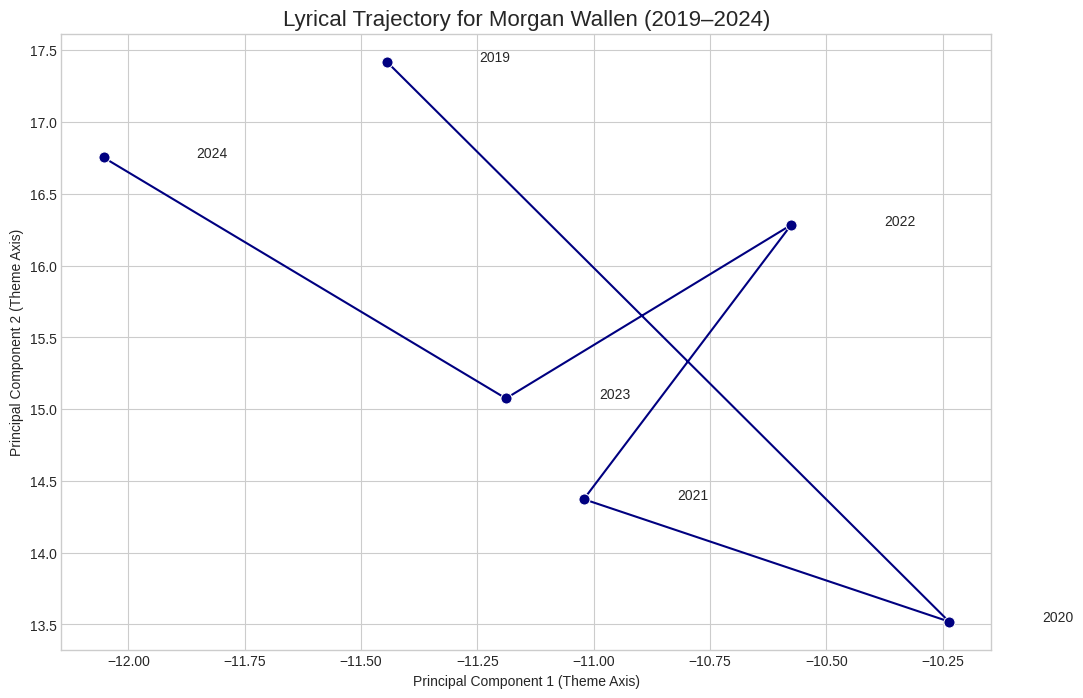

In [33]:
# 2

# artist and time frame for COVID.
artist_name = 'Morgan Wallen'
start_year = 2019
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

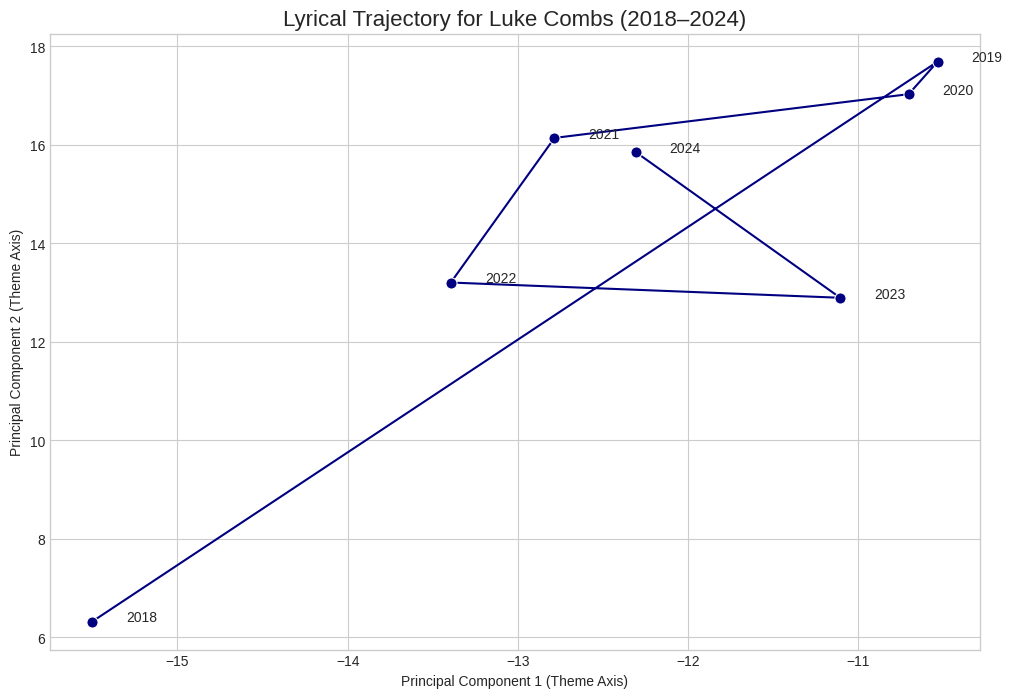

In [ ]:
# 3

# artist and time frame for COVID.
artist_name = 'Luke Combs'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

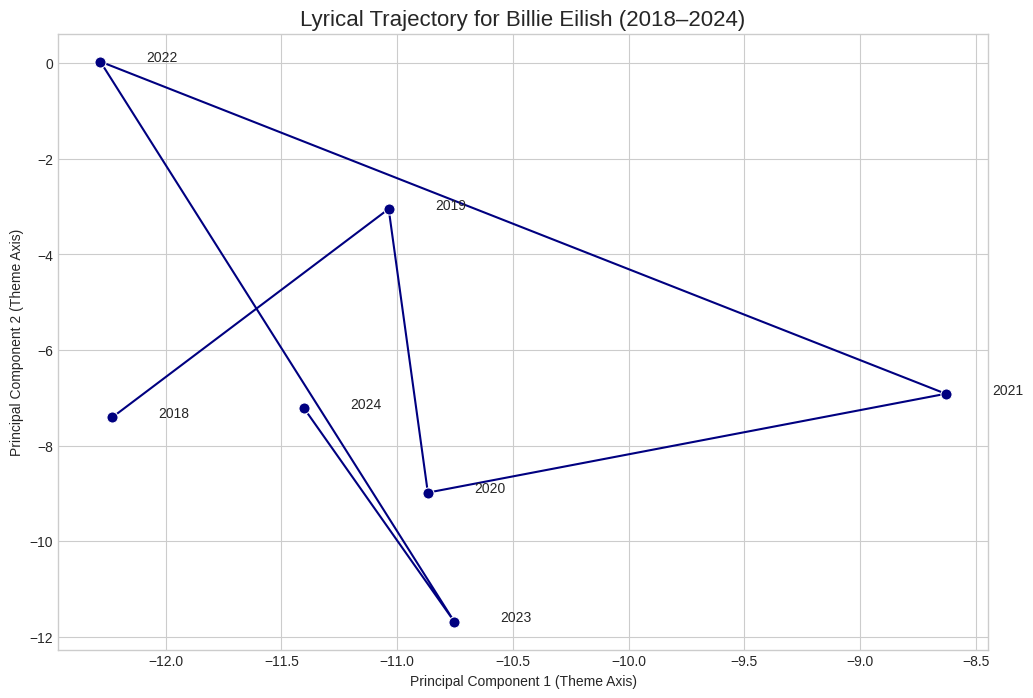

In [ ]:
# 4

# artist and time frame for COVID.
artist_name = 'Billie Eilish'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

Billie's trajectory is erratic and zig-zags across the thematic map from year to year.

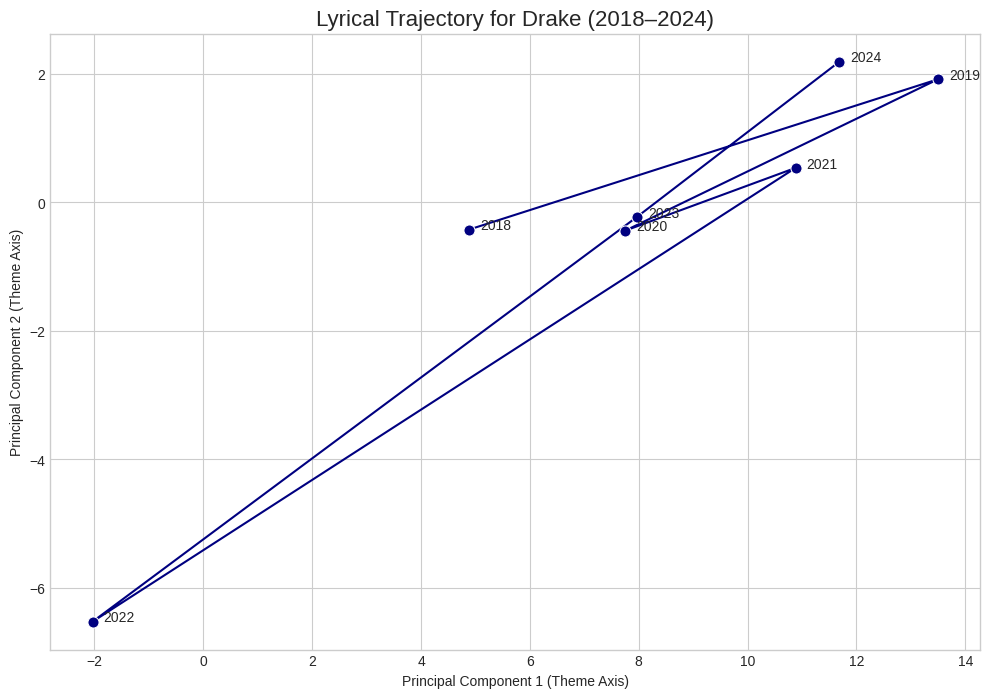

In [ ]:
# 5

# artist and time frame for COVID.
artist_name = 'Drake'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

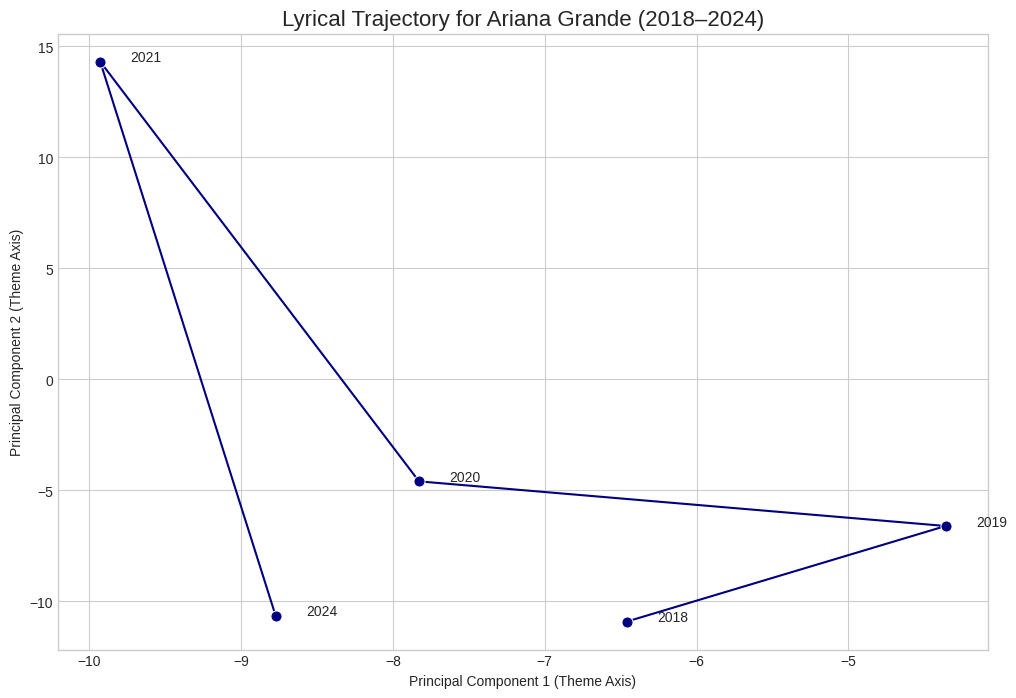

In [ ]:
# 6

# artist and time frame for COVID.
artist_name = 'Ariana Grande'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

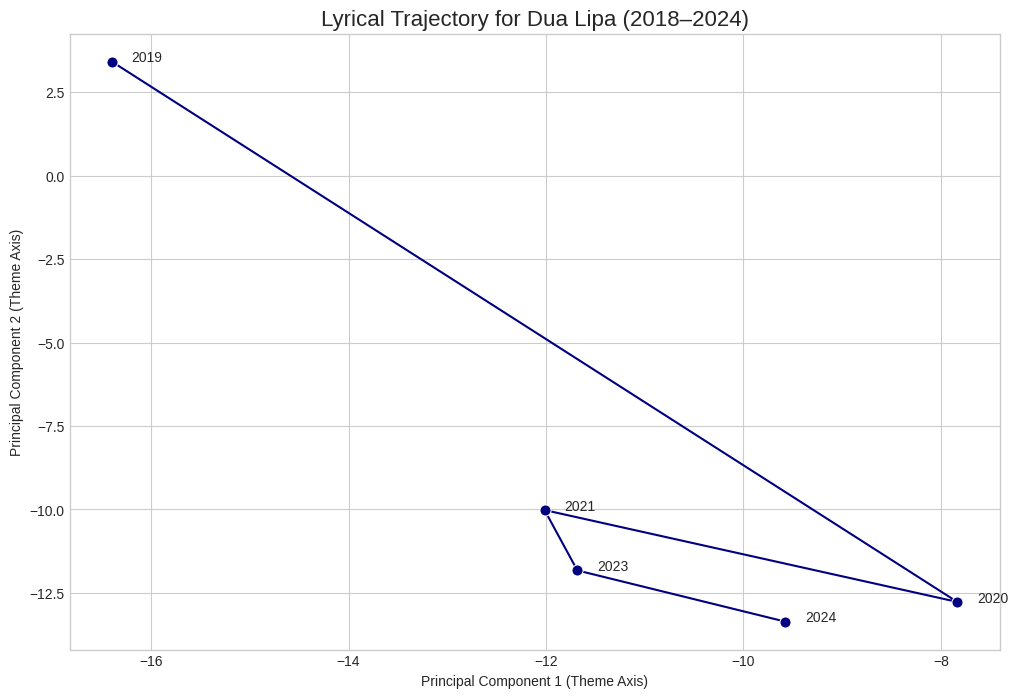

In [ ]:
# 7

# artist and time frame for COVID.
artist_name = 'Dua Lipa'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()


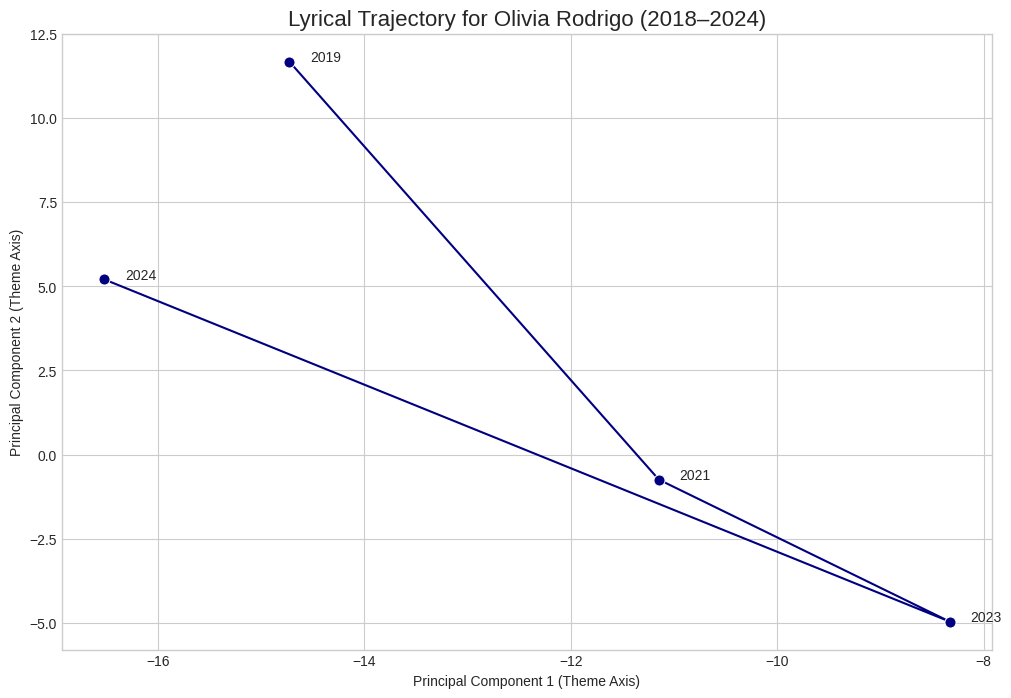

In [ ]:
# 8

# artist and time frame for COVID.
artist_name = 'Olivia Rodrigo'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

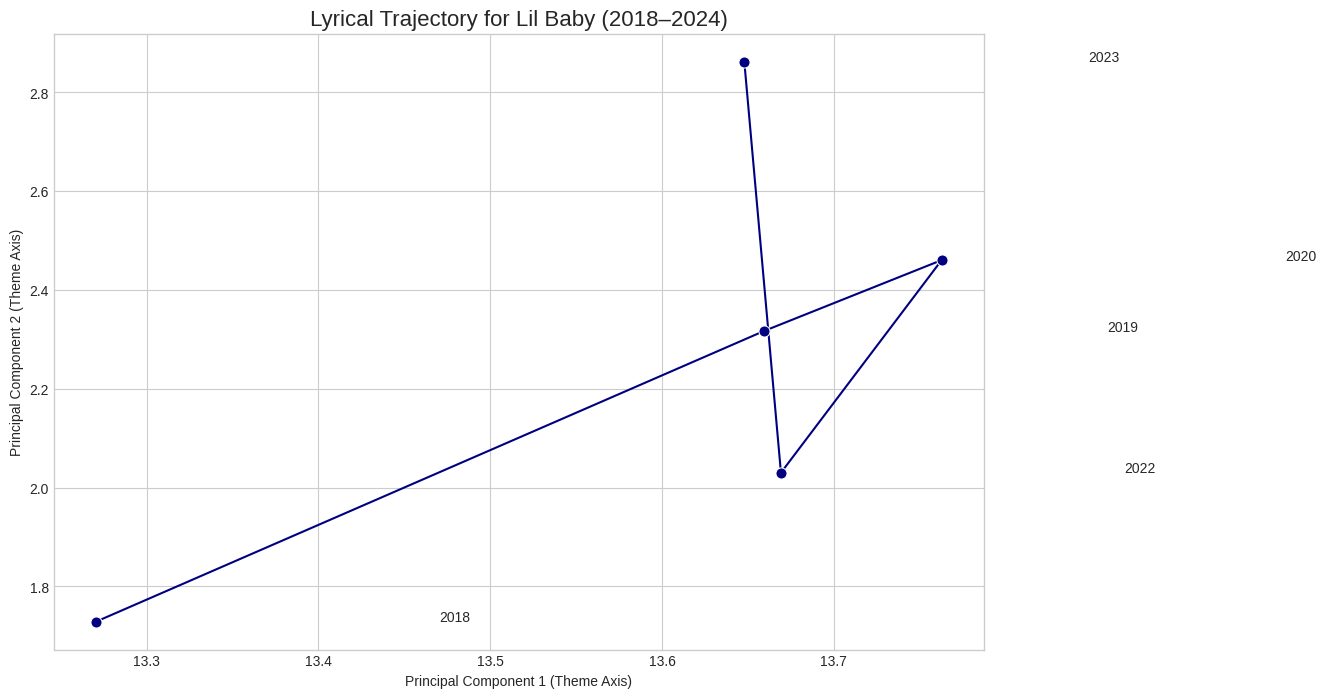

In [ ]:
# 9

# artist and time frame for COVID.
artist_name = 'Lil Baby'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

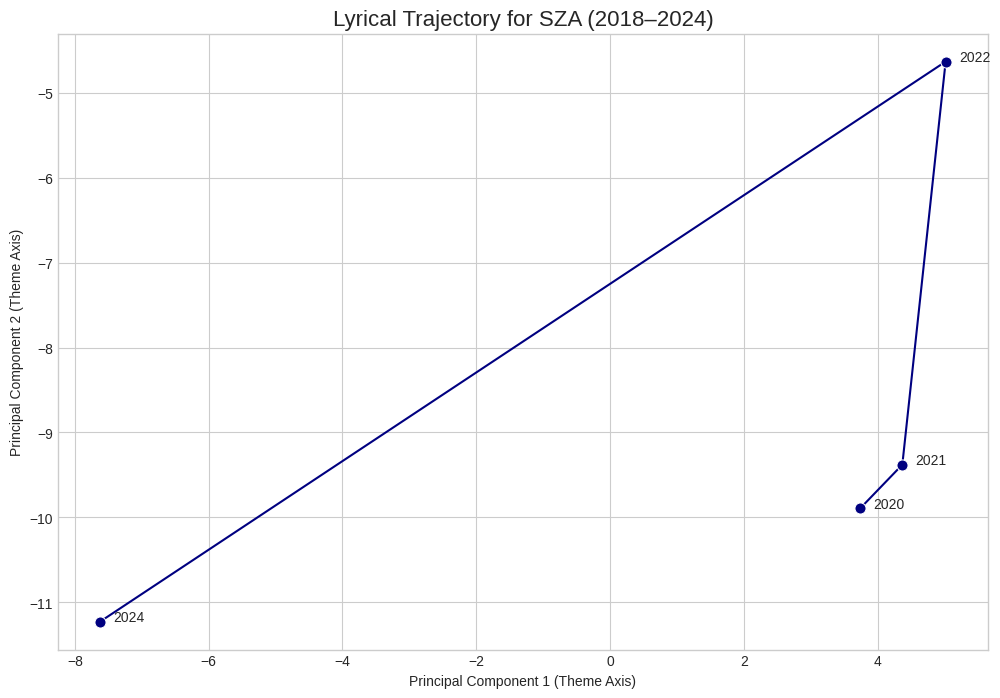

In [ ]:
# 10

# artist and time frame for COVID.
artist_name = 'SZA'
start_year = 2018
end_year = 2024

# filter df.
df_artist_period = df[(df['artist'] == artist_name) & (df['year'] >= start_year) & (df['year'] <= end_year)].copy()

# group by year and calculate the average theme (PCA components).
df_yearly_trajectory = df_artist_period.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()

if len(df_yearly_trajectory) < 2:
    print(f"Not enough yearly data for {artist_name} between {start_year} and {end_year}.")
else:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_yearly_trajectory, x='pca_1', y='pca_2', sort=False, marker='o', markersize=8,color='navy')
    for i, point in df_yearly_trajectory.iterrows():
        plt.text(point['pca_1'] + 0.2, point['pca_2'], str(int(point['year'])))

    plt.title(f"Lyrical Trajectory for {artist_name} ({start_year}–{end_year})", fontsize=16)
    plt.xlabel('Principal Component 1 (Theme Axis)')
    plt.ylabel('Principal Component 2 (Theme Axis)')
    plt.grid(True)
    plt.show()

Visualization 3: Zeitgeist Analysis

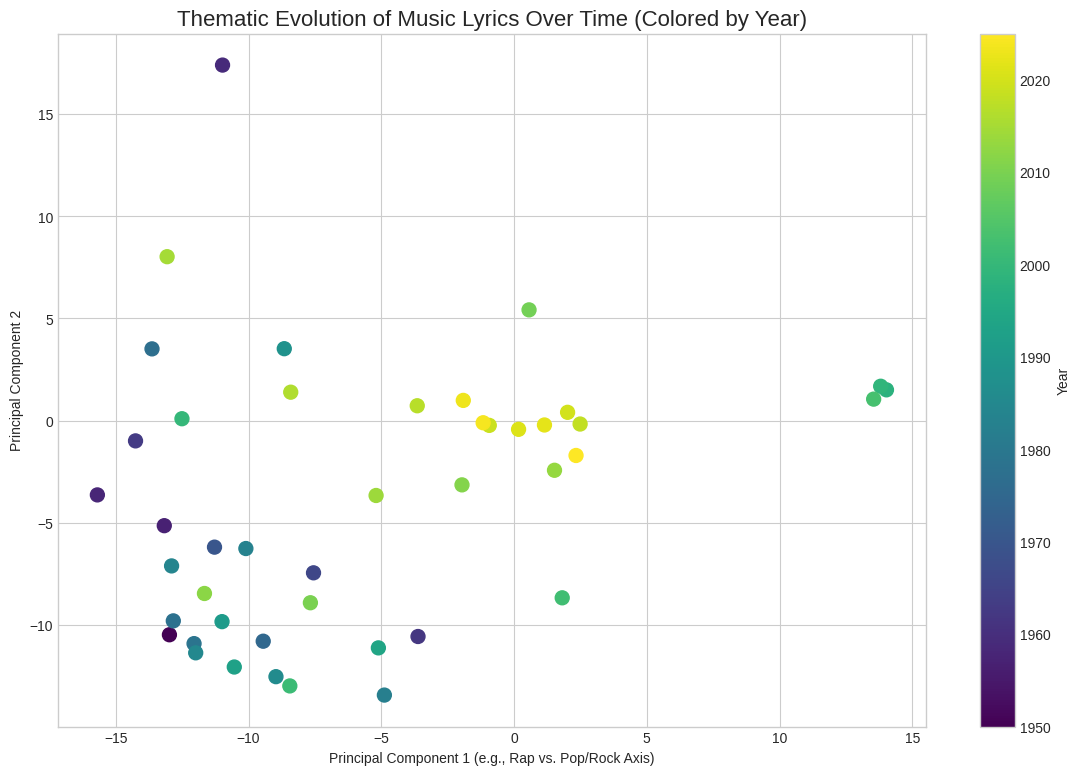

In [ ]:
# group by year and find the average lyrical theme for that year.
df_yearly_avg = df.groupby('year')[['pca_1', 'pca_2']].mean().reset_index()
plt.figure(figsize=(14, 9))

scatter = plt.scatter(x=df_yearly_avg['pca_1'], y=df_yearly_avg['pca_2'], c=df_yearly_avg['year'], cmap='viridis', s=100)

# add color bar.
plt.colorbar(scatter, label='Year')

plt.title('Thematic Evolution of Music Lyrics Over Time (Colored by Year)', fontsize=16)
plt.xlabel('Principal Component 1 (e.g., Rap vs. Pop/Rock Axis)')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Visualization 4: Correlation with GDP growth rate

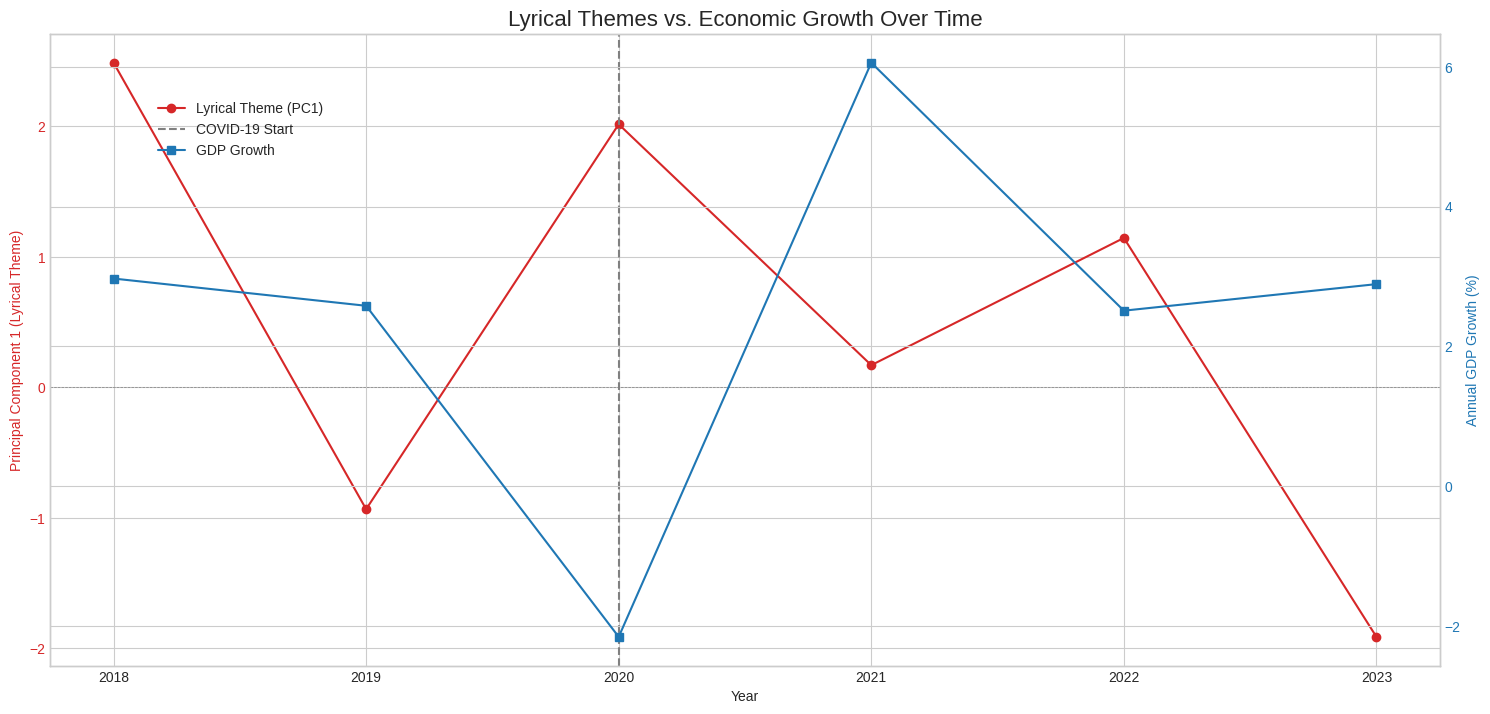

In [ ]:
eco_data = {
    'year': range(2018, 2024),
    'gdp_growth_percent': [
        2.97,  # 2018
        2.58,  # 2019
        -2.16, # 2020 (COVID-19 Recession)
        6.06,  # 2021 (Post-COVID Rebound)
        2.51,  # 2022
        2.89   # 2023
    ]
}

df_eco = pd.DataFrame(eco_data)

# merge with yearly lyrical data.
df_merged_analysis = pd.merge(df_yearly_avg, df_eco, on='year')

# create a dual-axis plot.
fig, ax1 = plt.subplots(figsize=(15, 7))

# plot the lyrical theme axis (PC1).
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Principal Component 1 (Lyrical Theme)', color=color)
ax1.plot(df_merged_analysis['year'], df_merged_analysis['pca_1'], color=color, marker='o', label='Lyrical Theme (PC1)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--')

# create a second y-axis for the GDP data.
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Annual GDP Growth (%)', color=color)
ax2.plot(df_merged_analysis['year'], df_merged_analysis['gdp_growth_percent'], color=color, marker='s', label='GDP Growth')
ax2.tick_params(axis='y', labelcolor=color)

# add a vertical line for the start of COVID.
ax1.axvline(x=2020, color='grey', linestyle='--', label='COVID-19 Start')

fig.tight_layout()
plt.title('Lyrical Themes vs. Economic Growth Over Time', fontsize=16)
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()

COVID serves as a key case study, showing that during economic crisis, lyrical themes followed their own distinct trajectory. This suggests that music's role in culture is more nuanced than being a mirror of the economy.

Where the GDP numbers is from: https://www.macrotrends.net/global-metrics/countries/usa/united-states/gdp-growth-rate

Visualization 5: Lyric Theme Evolution

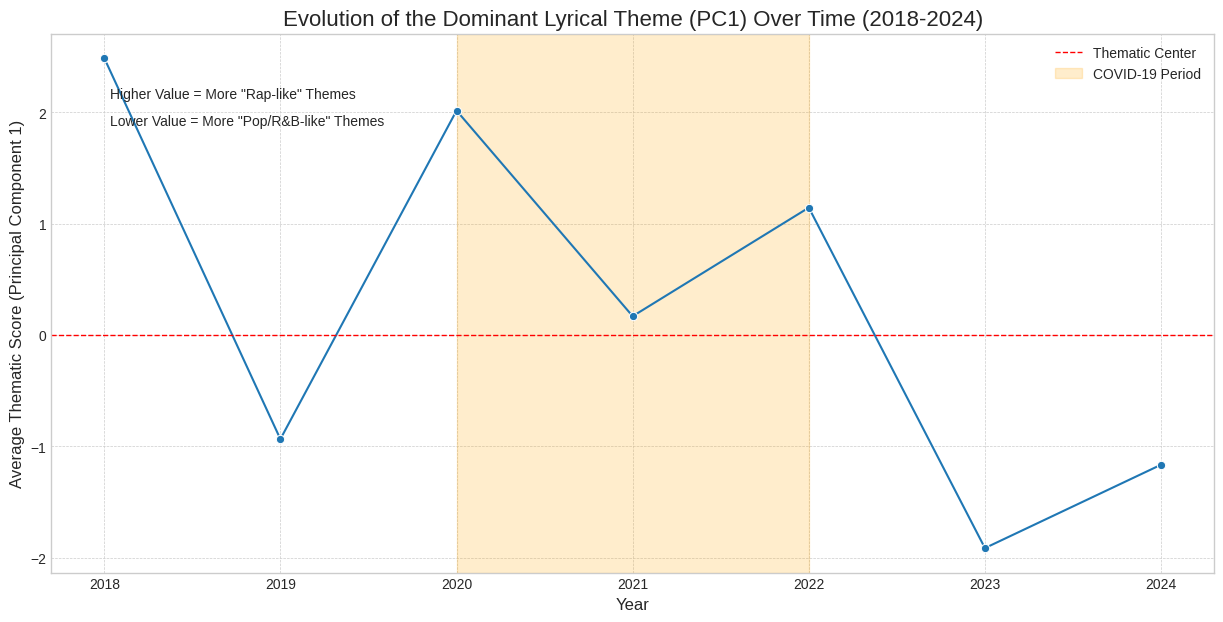

In [ ]:
# group by year and calculate the average thematic score (PC1).
df_filtered = df[(df['year'] >= 2018) & (df['year'] <= 2024)]
df_yearly_theme = df_filtered.groupby('year')['pca_1'].mean().reset_index()
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_yearly_theme, x='year', y='pca_1', marker='o')

# add context and annotations.
plt.title('Evolution of the Dominant Lyrical Theme (PC1) Over Time (2018-2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Thematic Score (Principal Component 1)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# add a horizontal line at 0 to show the crossover point.
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Thematic Center')

# annotate what the axis means based on your earlier plot.
plt.text(0.05, 0.9, 'Higher Value = More "Rap-like" Themes', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.85, 'Lower Value = More "Pop/R&B-like" Themes', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# highlight the COVID period for analysis.
plt.axvspan(2020, 2022, color='orange', alpha=0.2, label='COVID-19 Period')

plt.legend()
plt.show()

The COVID-19 pandemic did not cause an immediate lyrical shift, but its prolonged impact is clearly visible in 2021 with a significant move towards more personal and emotional "Pop/R&B-like" themes.

Visualization 6: Yearly Average Lyrical Themes

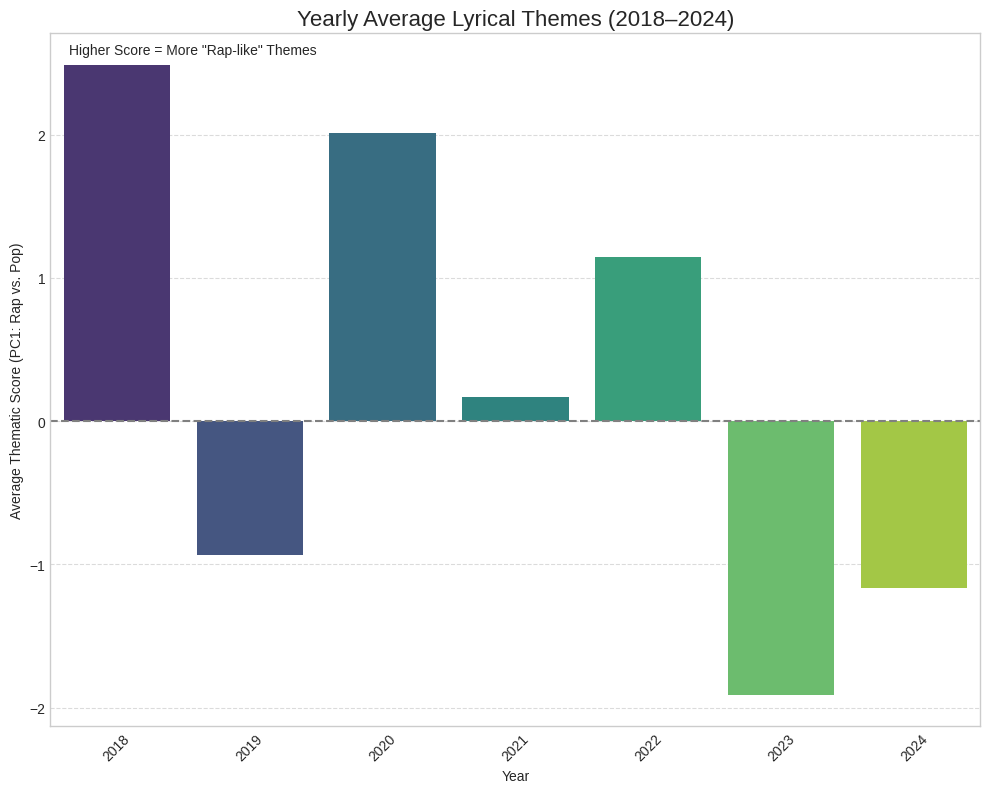

In [ ]:
# filter df for time frame.
event_era_df = df_yearly_avg[(df_yearly_avg['year'] >= 2018) & (df_yearly_avg['year'] <= 2024)]

plt.figure(figsize=(12, 9))

barplot = sns.barplot(data=event_era_df, x='year', y='pca_1', palette='viridis')

plt.axhline(0, color='grey', linestyle='--')
plt.title('Yearly Average Lyrical Themes (2018–2024)', fontsize=16)
plt.ylabel('Average Thematic Score (PC1: Rap vs. Pop)')
plt.xlabel('Year')
plt.text(0.02, 0.97, 'Higher Score = More "Rap-like" Themes', transform=plt.gca().transAxes)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Visualization 7: Thematic Analysis

--- Genre Distribution for 'Politics' Themed Songs ---
primary_tag
rap           0.481481
pop           0.234568
country       0.111111
r&b           0.086420
electronic    0.037037
Name: proportion, dtype: float64


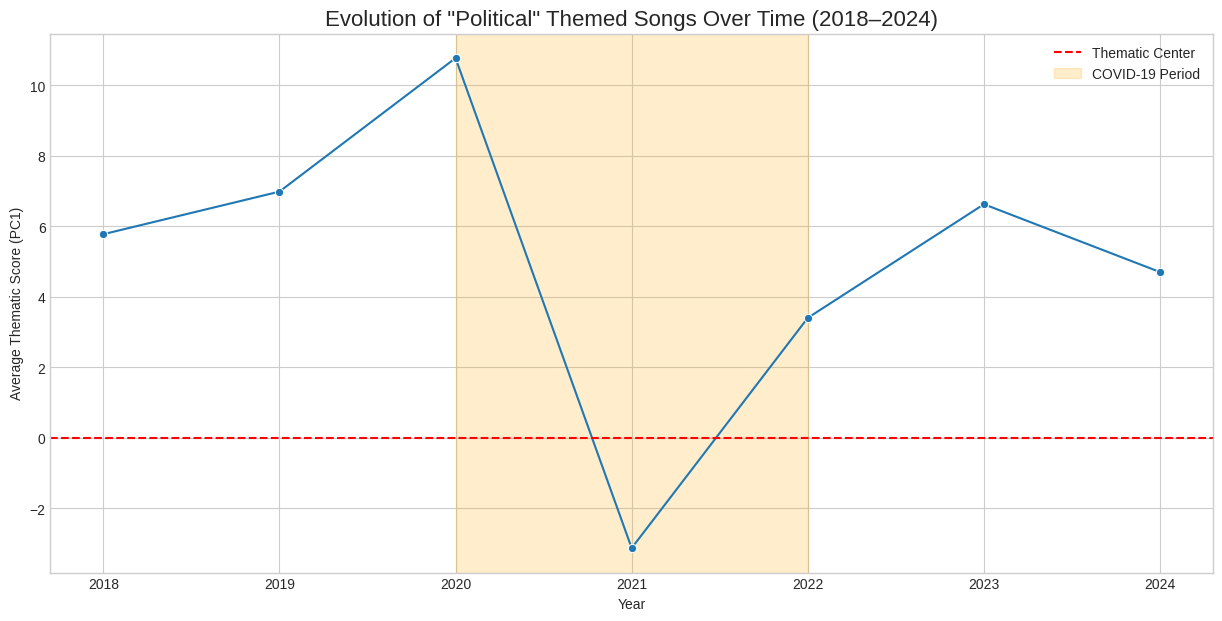

In [ ]:
# find all songs that mention "politics" or related terms.
df_politics = df[df['lyrics_clean'].str.contains('president|vote|freedom|protest', case=False)]

# analyze the genre distribution within the political theme.
print("--- Genre Distribution for 'Politics' Themed Songs ---")
print(df_politics['primary_tag'].value_counts(normalize=True).head())

# filter the 'political' songs for the 2018-2024 period.
df_politics_filtered = df_politics[(df_politics['year'] >= 2018) & (df_politics['year'] <= 2024)].copy()

# plot.
df_politics_yearly = df_politics_filtered.groupby('year')['pca_1'].mean().reset_index()
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_politics_yearly, x='year', y='pca_1', marker='o')
plt.title('Evolution of "Political" Themed Songs Over Time (2018–2024)', fontsize=16)
plt.ylabel('Average Thematic Score (PC1)')
plt.xlabel('Year')
plt.axhline(0, color='red', linestyle='--', label='Thematic Center')

# highlight the COVID period for analysis.
plt.axvspan(2020, 2022, color='orange', alpha=0.2, label='COVID-19 Period')

plt.grid(True)
plt.legend()
plt.show()

--- Genre Distribution for 'Love' Themed Songs ---
primary_tag
rap           0.359340
pop           0.217120
country       0.155595
r&b           0.150245
electronic    0.061079
Name: proportion, dtype: float64


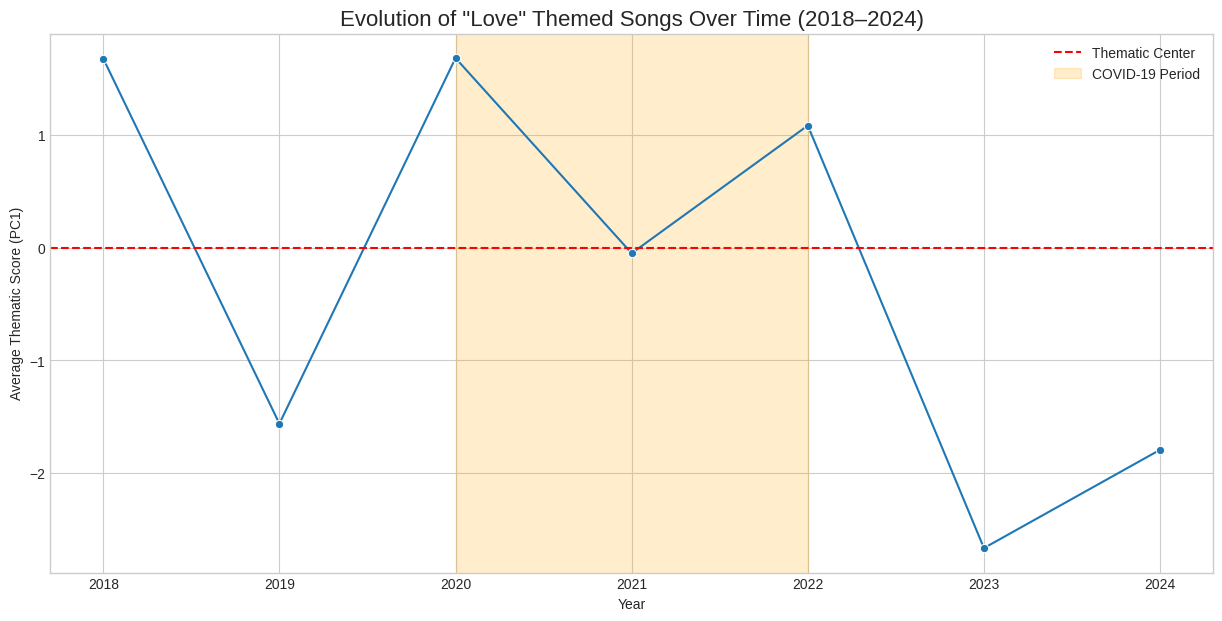

In [ ]:
# find all songs that mention "love" or related terms.
df_love = df[df['lyrics_clean'].str.contains('love|heart|baby', case=False)]

# analyze the genre distribution within the love theme.
print("--- Genre Distribution for 'Love' Themed Songs ---")
print(df_love['primary_tag'].value_counts(normalize=True).head())

# filter the 'love' songs for the 2018-2024 period.
df_love_filtered = df_love[(df_love['year'] >= 2018) & (df_love['year'] <= 2024)].copy()

# plot.
df_love_yearly = df_love_filtered.groupby('year')['pca_1'].mean().reset_index()
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_love_yearly, x='year', y='pca_1', marker='o')
plt.title('Evolution of "Love" Themed Songs Over Time (2018–2024)', fontsize=16)
plt.ylabel('Average Thematic Score (PC1)')
plt.xlabel('Year')
plt.axhline(0, color='red', linestyle='--', label='Thematic Center')
plt.grid(True)

# highlight the COVID period for analysis.
plt.axvspan(2020, 2022, color='orange', alpha=0.2, label='COVID-19 Period')

plt.legend()
plt.show()

--- Genre Distribution for 'Money' Themed Songs ---
primary_tag
rap           0.737113
pop           0.103093
r&b           0.077320
country       0.040206
electronic    0.023711
Name: proportion, dtype: float64


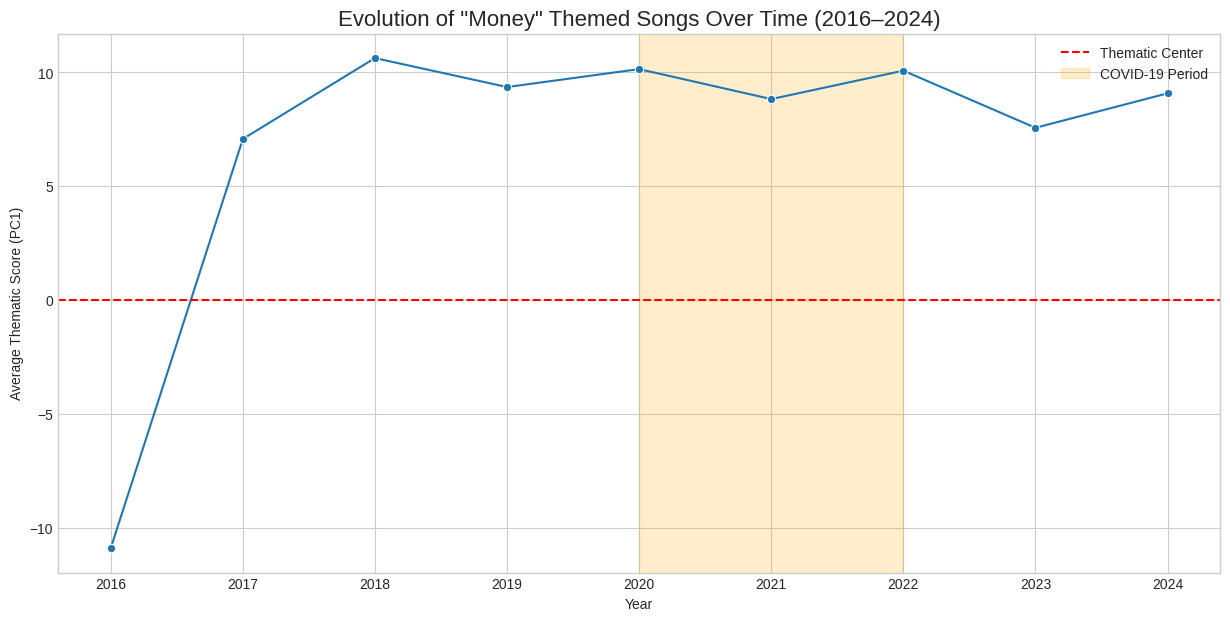

In [ ]:
# find all songs that mention "money" or related terms.
df_money = df[df['lyrics_clean'].str.contains('money|cash|rich|dollars', case=False)]

# analyze the genre distribution within the money theme.
print("--- Genre Distribution for 'Money' Themed Songs ---")
print(df_money['primary_tag'].value_counts(normalize=True).head())

# filter the 'money' songs for the 2016-2024 period.
df_money_filtered = df_money[(df_money['year'] >= 2016) & (df_money['year'] <= 2024)].copy()

# plot.
df_money_yearly = df_money_filtered.groupby('year')['pca_1'].mean().reset_index()
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_money_yearly, x='year', y='pca_1', marker='o')
plt.title('Evolution of "Money" Themed Songs Over Time (2016–2024)', fontsize=16)
plt.ylabel('Average Thematic Score (PC1)')
plt.xlabel('Year')
plt.axhline(0, color='red', linestyle='--', label='Thematic Center')
plt.grid(True)

# highlight the COVID period for analysis.
plt.axvspan(2020, 2022, color='orange', alpha=0.2, label='COVID-19 Period')

plt.legend()
plt.show()